In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import shap
shap.initjs()

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from lime.lime_tabular import LimeTabularExplainer
from lime import lime_tabular

In [2]:
df = pd.read_csv('src/data.csv', sep =';')
df['Target'] = df['Target'].map({'Dropout': 0, 'Enrolled': 1, 'Graduate': 2})
df.head(1)
#print(df.columns)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.0,0,10.8,1.4,1.74,0


In [ ]:
outcomes = [0, 1, 2]  # dropped out, enrolled, graduated
data_for_boxplot = [df.loc[df['Target'] == t, 'Age at enrollment'] for t in outcomes]

plt.boxplot(data_for_boxplot, labels=['Dropped out','Enrolled','Graduate'])
plt.title('Age at Enrollment by Academic Outcome')
plt.xlabel('Academic Outcome')
plt.ylabel('Age')
plt.show()

#### Feature Selection

In order to determine the features to use in the model, we check the correlation (using heatmap) of the Curricular units features first. We will eliminate the highly correlated to reduce redundancy.

In [ ]:
# In selecting what to compare, focus on truly numeric columns (continuous or discrete). 
# Avoid using multi-level nominal categorical variables as numeric, since these are categorical just stored as integers

sem1 = ['Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)',
        'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)',
        'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)']

sem2 = ['Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)',
        'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)',
        'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)']

# Compute correlation between 1st and 2nd sem variables
sem_corr = df[sem1 + sem2].corr()

sns.heatmap(sem_corr, cmap='coolwarm', center=0, annot=True, fmt=' .1g')


Within the 1st Semester

    (Credited, Enrolled): 0.8
    (Enrolled, Evaluations): 0.7
    (Enrolled, Approved): 0.8
    (Approved, Grade): 0.7

Between 1st and 2nd Semester

    (1st Sem Credited, 2nd Sem Credited): 0.9
    (1st Sem Enrolled, 2nd Sem Credited): 0.9
    (1st Sem Enrolled, 2nd Sem Enrolled): 0.9
    (1st Sem Approved, 2nd Sem Approved): 0.9

    (1st Sem Approved, 2nd Sem Enrolled): 0.7
    (1st Sem Grade, 2nd Sem Enrolled): 0.7



Within the 2nd Semester

    (Credited, Enrolled): 0.8
    (Enrolled, Evaluations): 0.7
    (Enrolled, Approved): 0.7
    (Approved, Grade): 0.8

Takeaway:
1. Higher Enrollment Leads to More Engagement & Success
    - Students who enroll in more courses tend to take more evaluations (0.7) and pass more subjects (0.8) in both semesters.

2. Performance in the 1st Semester Strongly Predicts 2nd Semester Success
    - Students who earn credits in the 1st semester are highly likely (0.9) to earn them in the 2nd semester.
    - Those who pass more courses in the 1st semester also tend to pass more in the 2nd semester (0.9).

3. Grades Are Consistently Linked to Approved Courses
    - A strong correlation between approved courses and final grades (0.7–0.8) means students who pass more subjects generally score higher.

4. Credit Accumulation is Key to Progression
    - Students who earn credits in the 1st semester are almost guaranteed to enroll and earn credits in the 2nd semester (0.9).

5. Struggling in the 1st Semester Can Impact Future Enrollment
    - Lower grades and approvals in the 1st semester reduce the likelihood of enrolling in the 2nd semester (0.7 correlation).

Often, highly correlated features create redundancy in the dataset: they essentially carry the same information. Removing (or consolidating) the most correlated features is a feature-selection strategy to simplify the model. 

# **Feature Selection Based on Correlation Analysis**

## **1. High‐Enrollment Cluster**
This cluster includes:
- `1st sem (credited)`, `1st sem (enrolled)`, `2nd sem (credited)`, `2nd sem (enrolled)`

### **Observed Correlations:**
- `1st sem (credited) ↔ 1st sem (enrolled) ≈ 0.8`
- `1st sem (credited) ↔ 2nd sem (credited) ≈ 0.9`
- `1st sem (enrolled) ↔ 2nd sem (credited) ≈ 0.9`
- `1st sem (enrolled) ↔ 2nd sem (enrolled) ≈ 0.8`

### **Choice:**
**Keep:**  
- `1st sem (enrolled)` → A straightforward measure of how many classes a student took early on.  
- `2nd sem (enrolled)` → A parallel measure for the second semester.  

**Remove:**  
- `1st sem (credited)`  
- `2nd sem (credited)`  
(Because they are highly redundant with "enrolled").  

---

## **2. Performance‐Type Cluster**
This cluster includes:
- `1st sem (evaluations)`, `1st sem (approved)`, `1st sem (grade)`
- `2nd sem (evaluations)`, `2nd sem (approved)`, `2nd sem (grade)`

### **Observed Correlations (examples):**
- `1st sem (enrolled) ↔ 1st sem (approved) ≈ 0.8`
- `2nd sem (approved) ↔ 2nd sem (grade) ≈ 0.8`
- `2nd sem (evaluations) ↔ 2nd sem (approved) ≈ 0.8`

### **Choice:**
**For each semester, choose between:**
- **"Approved"** → Measures **how many** classes were passed.
- **"Grade"** → Measures the **average quality** of performance.

**Decision:**  
- If **(approved) is enough to track success**, remove (grade).  
- If **(evaluations) is strongly correlated with (approved)**, remove (evaluations).  

---

---

**Final Kept Columns**
- `1st sem (enrolled)`
- `1st sem (approved)`
- `1st sem (without evaluations)`
- `2nd sem (enrolled)`
- `2nd sem (approved)`
- `2nd sem (without evaluations)`

---

## **Why Remove Redundant Features?**
**Simplifies the model** - Reduces complexity & training time.  
**Easier interpretation** - Avoids competing features in models.  
**Reduces multicollinearity** - High correlation can **destabilize** linear models, making coefficients or feature importance measures unreliable.  



In [ ]:
# Define numeric columns
# In selecting what to compare, focus on truly numeric columns (continuous or discrete). 
# Avoid using multi-level nominal categorical variables as numeric, since these are categorical just stored as integers
# Also, we will use the final kept columns
numeric_cols = ['Age at enrollment', 'Admission grade', 'Previous qualification (grade)', 'Unemployment rate', 'Inflation rate','GDP',
                'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (without evaluations)',
                'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (evaluations)']

# Compute correlation matrix
corr_matrix = pd.DataFrame(df[numeric_cols],columns=numeric_cols).corr()

sns.heatmap(corr_matrix,
            cmap = 'coolwarm',
            center = 0,
            annot = True,
            fmt = ' .1g')

With the final heatmap above, we can conclude that there are no features left from the curricular units, related to other continuous features. 0.6 correlation is not a sign of redundancy

#### Modeling

- We also train 2 models, XGB and RF to determine which is better

#### Train the XGB model

In [3]:
# Define target and features
y = df['Target']
X = df[['Age at enrollment', 'Admission grade', 'Previous qualification (grade)', 'Gender', 'Displaced',
        'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Scholarship holder',
        'Daytime/evening attendance\t', 'International',
        'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (without evaluations)',
        'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (evaluations)']]

# Ensure the same train-test split for both models
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
# Hyperparameter grid for XGBoost
param_dist_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_base = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric='merror',
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Randomized Search for XGBoost
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist_xgb,
    scoring='accuracy',
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42
)

random_search_xgb.fit(X_train, y_train)

# Best hyperparameters found
best_params_xgb = random_search_xgb.best_params_
print("\nBest Parameters (XGBoost):", best_params_xgb)

# Train final XGBoost model
best_model_xgb = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric='merror',
    random_state=42,
    n_jobs=-1,
    **best_params_xgb  # Use best hyperparameters
)

best_model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  # Early stopping on test set
    verbose=False
)

# Predictions & Evaluation
y_pred_xgb = best_model_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"\nXGBoost Accuracy: {accuracy_xgb:.2f}")
print("\nXGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Parameters (XGBoost): {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

XGBoost Accuracy: 0.76

XGBoost Confusion Matrix:
 [[237  34  45]
 [ 35  48  68]
 [  9  23 386]]

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.75      0.79       316
           1       0.46      0.32      0.38       151
           2       0.77      0.92      0.84       418

    accuracy                           0.76       885
   macro avg       0.69      0.66      0.67       885
weighted avg       0.74      0.76      0.75       885



#### Train the RF model

In [ ]:
# Define target and features
y = df['Target']
X = df[['Age at enrollment', 'Admission grade', 'Previous qualification (grade)', 'Gender', 'Displaced',
        'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Scholarship holder',
        'Daytime/evening attendance\t', 'International',
        'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (without evaluations)',
        'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (evaluations)']]

# Ensure the same train-test split for both models
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf_base = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1  # Use all cores
)

grid_search_rf.fit(X_train, y_train)

# Get best model
best_model_rf = grid_search_rf.best_estimator_

# Predictions & Evaluation
y_pred_rf = best_model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("\nBest Parameters (RF):", grid_search_rf.best_params_)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print("\nRandom Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

With both accuracy same, we can choose any model

#### Get the SHAP values then plot

In [4]:
# get SHAP values
explainer = shap.Explainer(best_model_xgb)
shap_values = explainer(X)

#shap_values = explainer(X[0:100]) # run this if only for 100 observations

In [5]:
np.shape(shap_values.values)
# (number of data points, number of features, SHAP values)
# Define class labels
class_labels = {0: "Dropout", 1: "Enrolled", 2: "Graduated"}

##### Waterfall plot
Best for showing how each feature affects one data point (one student)

Each waterfall plot focuses on **one instance** (one student) and **one class** (Dropout, Enrolled, or Graduated). The model predicts a score (e.g., log-odds) for each class. SHAP decomposes that score into contributions from each feature.

##### Key Elements

1. Base Value (E[f(x)]) 
   - This is the model’s *baseline* for that particular class, often the average model output if we had no information about the student’s features.

2. Feature Contributions  
   - **Red bars** push the prediction *upward* (increasing probability or log-odds for that class).  
   - **Blue bars** push the prediction *downward* (decreasing probability/log-odds).  
   - The length of each bar indicates how strongly that feature affects the final score.

3. Final Value (far right)  
   - This is the resulting model output (log-odds or probability) for that class, after adding/subtracting all feature contributions.  
   - Interpreting it: “Because of Feature X being 0/1/etc., we move from the base value to the final predicted value for this class.”


SHAP Analysis for Class: Dropout (Class 0)

Waterfall Plot (Single Prediction Breakdown)


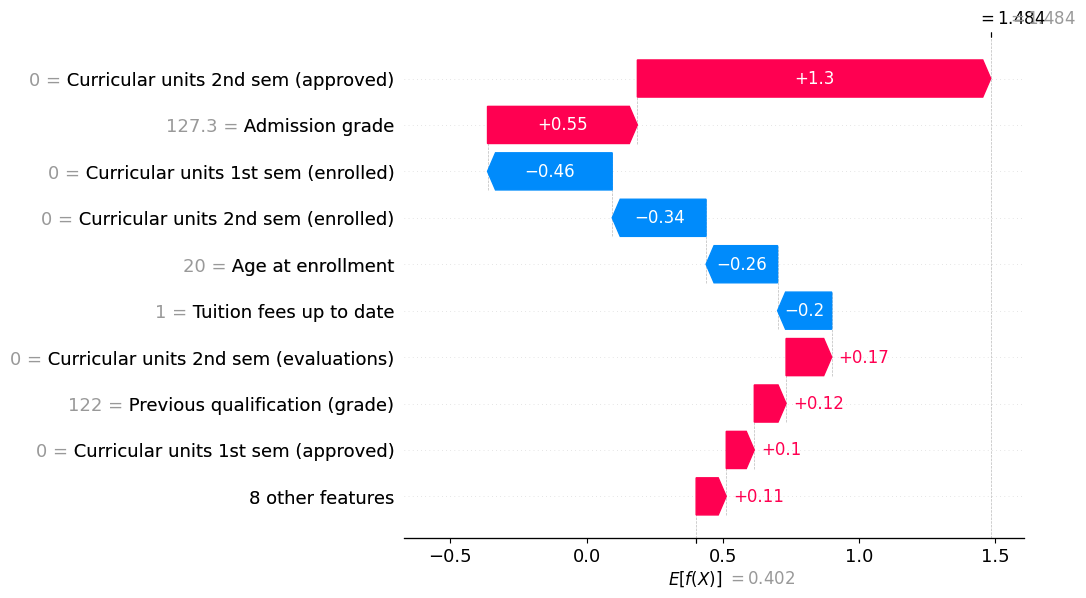


SHAP Analysis for Class: Enrolled (Class 1)

Waterfall Plot (Single Prediction Breakdown)


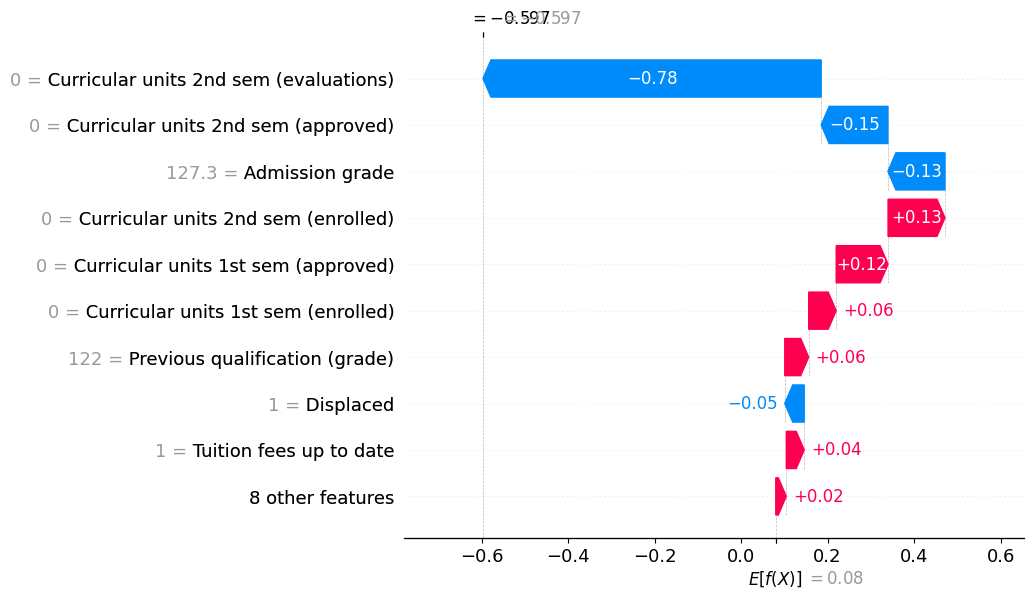


SHAP Analysis for Class: Graduated (Class 2)

Waterfall Plot (Single Prediction Breakdown)


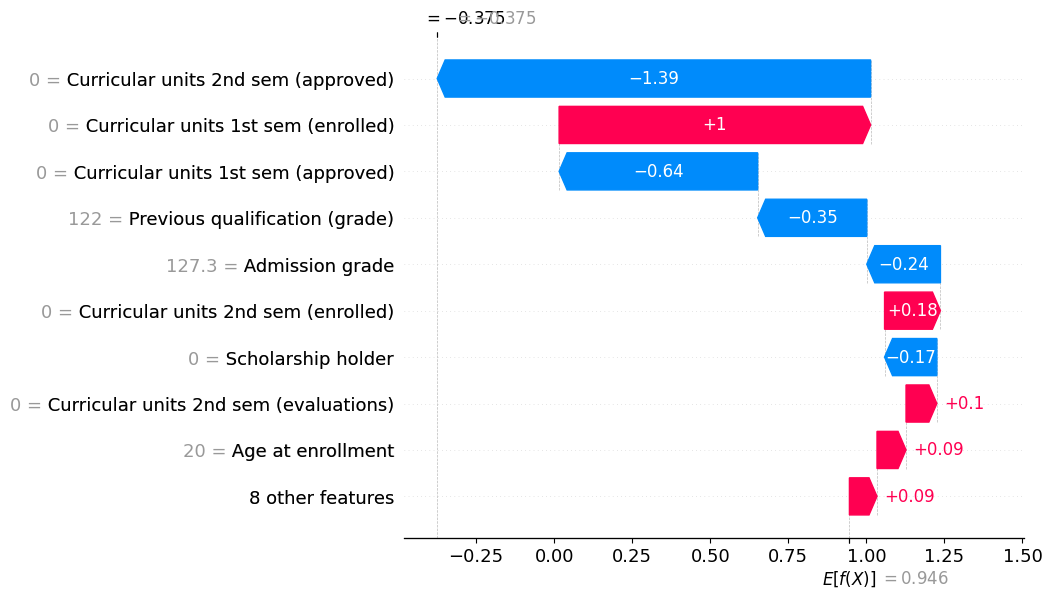

In [7]:
# Define class labels
class_labels = {0: "Dropout", 1: "Enrolled", 2: "Graduated"}

# Loop through all classes
for class_idx in range(3):  
    print(f"\nSHAP Analysis for Class: {class_labels[class_idx]} (Class {class_idx})\n")
    
    # Waterfall Plot (Explains SHAP values for the first instance)
    print("Waterfall Plot (Single Prediction Breakdown)")
    shap.plots.waterfall(shap_values[0][:, class_idx])  # First sample for this class
    plt.show()

##### Waterfall Plot Interpretation  
1. Dropout (Class 0)

Base Value: Around -1.48, the average model output (logit) for Dropout across the training set.

Main Positive (Red) Features:
Curricular units 2nd sem (approved) gives a large +1.3 push, meaning the student’s number of approved units in the second semester actually increases the Dropout logit. Admission grade contributes +0.55, indicating that the model finds this student’s admission grade correlates with higher dropout risk. Curricular units 1st sem (evaluations) and (approved) both add smaller positive pushes.

Main Negative (Blue) Features:
Curricular units 1st sem (enrolled) lowers the Dropout logit by -0.46, meaning more 1st‐semester enrollment signals a lower chance of dropping out. Curricular units 2nd sem (enrolled) reduces the Dropout logit by -0.34. Age at enrollment and tuition fees up to date also slightly reduce dropout risk.

Final Logit: Ends up around +1.48 after starting at -1.48. A positive logit suggests the model sees a relatively higher chance of dropout, though the actual predicted class depends on how this compares to the Enrolled and Graduate logits.

Counterintuitive Realizations: More second‐semester approved units might normally be viewed as good progress, but the model sees a pattern where it’s linked to dropout for this specific student, likely due to data correlations or interactions with other features.

2. Enrolled (Class 1)

Base Value: Around -0.60 for the Enrolled class.

Main Negative (Blue) Features:
Curricular units 2nd sem (evaluations) contributes -0.78, which is the largest downward push, suggesting that once a student completes a certain level of 2nd‐semester evaluations, they may no longer be simply enrolled and might drop out or graduate. Curricular units 2nd sem (approved) and Admission grade also pull the Enrolled logit down slightly, possibly indicating that students who accumulate many approved units or have certain admission‐grade profiles move on to graduate or leave.

Main Positive (Red) Features:
Curricular units 1st sem (approved) adds +0.12, signaling the student has some successful progress that keeps them in school. Curricular units 2nd sem (enrolled) contributes +0.10, suggesting active enrollment is a strong indicator of not having dropped out or graduated yet. Previous qualification (grade) and tuition fees up to date each add smaller positive contributions.

Final Logit: Ends around +0.08, slightly above zero. Whether the model ultimately predicts Enrolled depends on how that +0.08 compares with the Dropout and Graduate logits.

Counterintuitive Realizations: Admission grade being negative for Enrolled might seem odd, but the model could have learned that certain admission‐grade ranges correlate with either faster graduation or early dropout, thus lowering the chance of still being enrolled.

3. Graduate (Class 2)

Base Value: Around -0.38 for the Graduate class.

Main Negative (Blue) Features:
Curricular units 2nd sem (approved) contributes -1.39, which is a major push against the Graduation logit. A high count of 2nd‐semester approvals appears more typical of students who don’t finish on time or eventually drop out. Curricular units 1st sem (approved) lowers the logit for Graduation by -0.64 in this specific student’s context. Previous qualification (grade) and Admission grade also slightly reduce the Graduation logit.

Main Positive (Red) Features:
Curricular units 1st sem (enrolled) adds +1.0, which is a huge boost, implying that enrolling in enough 1st‐semester units strongly correlates with having already graduated. Scholarship holder contributes +0.18, indicating that scholarship students often do finish. Curricular units 2nd sem (evaluations), Age at enrollment, and other features each nudge the logit upward.

Final Logit: Ends around +0.95, which is fairly high, suggesting a strong inclination toward Graduate, assuming it exceeds the Dropout and Enrolled logits.

Counterintuitive Realizations: More approved units can be negative for Graduation if certain numbers of approved units correlate with a pattern that doesn’t lead to an actual diploma, possibly due to stalling out or partial completions.

##### Bar plot
Best for showing global effect of a feature or its global importance

In [ ]:
# Bar Plot (Global Feature Importance for this class)
print("Global Feature Importance")
shap.plots.bar(shap_values[:, :, class_idx])  
plt.show()

##### Summary Plot

Summary Plot (Feature Impact Across All Data)


c:\Users\joack\Desktop\XAI\myvenv\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  pl.tight_layout()
c:\Users\joack\Desktop\XAI\myvenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


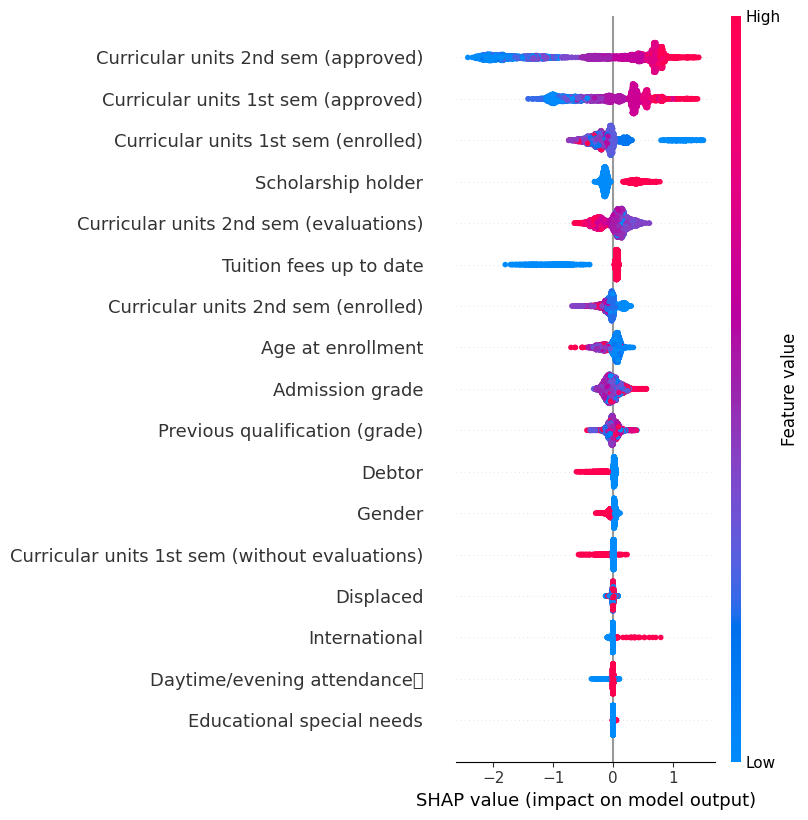

In [8]:
print("Summary Plot (Feature Impact Across All Data)")
shap.summary_plot(shap_values[:, :, class_idx], X)
plt.show()

##### Beeswarm (Summary) Plot Interpretation

Because red (high feature value) dots can appear on both the left (negative) and right (positive), it implies that the relationship is not purely linear. Some possible reasons:

- Interactions: A feature might have one effect at low admission grades and a different effect at high admission grades.
- Thresholds: Maybe approving more than “X” units flips the effect from positive to negative.
- Correlations: Another feature might override or amplify the effect of “approved units,” making it beneficial in some cases and harmful in others.

### Lime

In [10]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data = X_train.values,
    feature_names = X_train.columns.tolist(),
    class_names   = ['Dropout', 'Enrolled', 'Graduate'],
    mode          = 'classification'
)


In [12]:
i = 0  # pick any test index

exp = explainer.explain_instance(
    X_test.values[i],         # The instance to explain
    best_model_xgb.predict_proba,       # Probability function of your trained model
    num_features=8,            # Show top 8 features
    top_labels=3               # We have 3 classes, so show them all
)


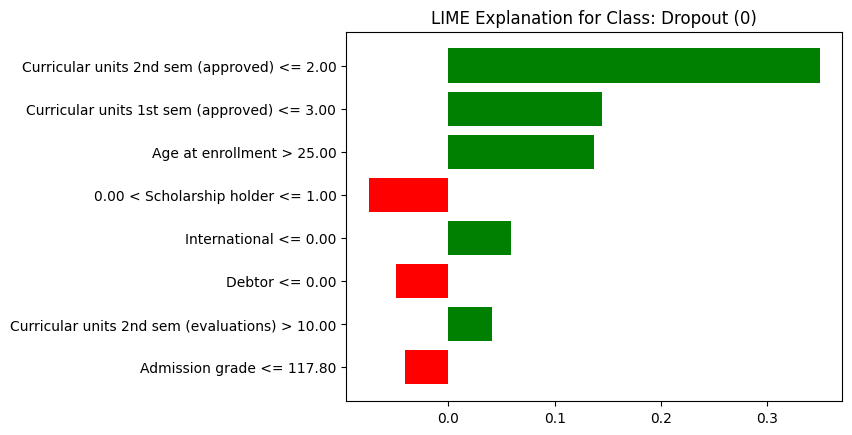

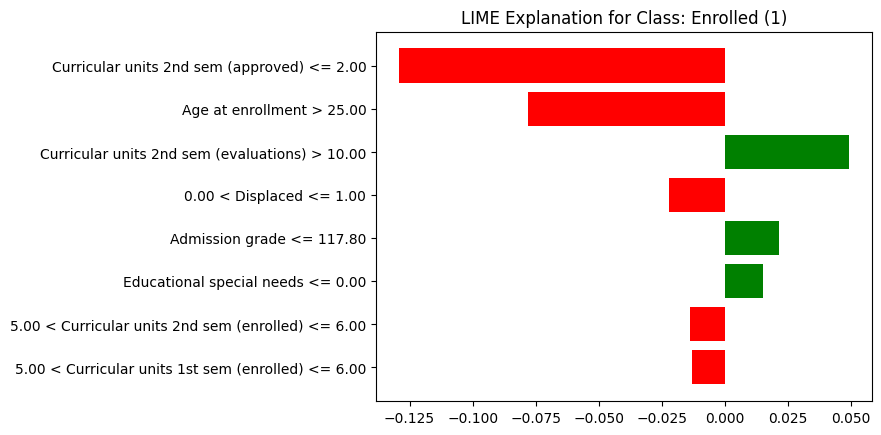

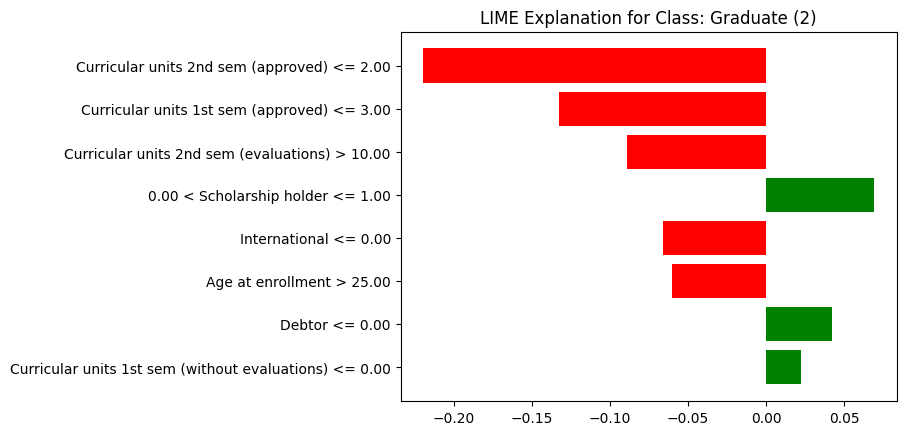

In [13]:
fig = exp.as_pyplot_figure(label=0)  # label=0 means "Dropout" class
plt.title("LIME Explanation for Class: Dropout (0)")
plt.show()

fig = exp.as_pyplot_figure(label=1)  # "Enrolled"
plt.title("LIME Explanation for Class: Enrolled (1)")
plt.show()

fig = exp.as_pyplot_figure(label=2)  # "Graduate"
plt.title("LIME Explanation for Class: Graduate (2)")
plt.show()


#### Lime Interpretation
The statement i = 0 sets the index of the test instance you want to explain. In this case, i = 0 means choosing the first instance (or row) from test dataset (X_test). When using X_test.values[i], we are extracting the feature values for that first test instance, which is then passed to LIME to generate a local explanation for the model's prediction on that particular instance.